## Using a Plain RNN Model to Predict Amazon Stock Prices

Juwonlo Siyanbade


### Import neccessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers \
import SimpleRNN, Activation, Dropout, Embedding, Dense, Reshape, SpatialDropout1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

## Reading and Preprocessing the Data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/NN/AMZN.csv')

In [3]:
len(df)

2517

The stock price data was gotten from https://www.nasdaq.com/market-activity/stocks/amzn/historical

The data contains 2517 values collected over 10 years(2012 - 2022)

In [4]:
# Preview data
df.head()

,Date,Close,Volume,Open,High,Low
0,11/02/2022,$92.12,135761800,$97.32,$97.74,$92.01
1,11/01/2022,$96.79,153370000,$103.99,$104.58,$96.06
2,10/31/2022,$102.44,99251400,$103.56,$104.87,$100.74
3,10/28/2022,$103.41,223133400,$97.91,$103.96,$97.66
4,10/27/2022,$110.96,129605400,$113.92,$114.12,$109.77


In [5]:
# Remove $ from prices and cast as float
df['Close'] = df['Close'].str.replace('$', '').astype(float)
df['Open'] = df['Open'].str.replace('$', '').astype(float)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning

In [6]:
# Convert Date column to numeric data type
df["Date"] = pd.to_numeric(df["Date"], errors='ignore')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2517 non-null   object 
 1   Close   2517 non-null   float64
 2   Volume  2517 non-null   int64  
 3   Open    2517 non-null   float64
 4   High    2517 non-null   float64
 5   Low     2517 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 118.1+ KB


### Plot the closing price vs the date

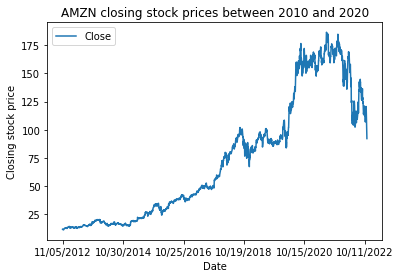

In [8]:
# Sort the data to have the more current data points on the right
df = df.sort_index(ascending=False)
df.plot("Date", "Close")
plt.title("AMZN closing stock prices between 2010 and 2020")
plt.ylabel('Closing stock price')
plt.show()

From the plot above, it is observed that the stock had its highest closing values between 2019 and 2022, soaring highest in 2021. The jump can be traced to the rise in patronage of the e-commerce giant during the COVID-19 pandemic.

### Extract the closing values and plot 

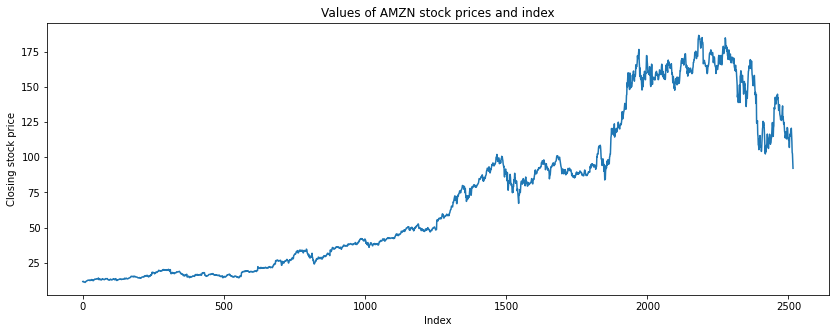

In [9]:
closing_data = df.Close.values.reshape(-1,1)
plt.figure(figsize=[14,5])
plt.title("Values of AMZN stock prices and index")
plt.xlabel('Index')
plt.ylabel('Closing stock price')
plt.plot(closing_data)
plt.show()

### Assign train and test data

In [10]:
train_recs = int(len(df) * 0.75)
train_data = closing_data[:train_recs]
test_data = closing_data[train_recs:]
len(train_data), len(test_data)

(1887, 630)

### Scale the train and test data

In [11]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

### Create a get_lookback function and get lookback data for the train and test data using a lookback period

In [12]:
def get_lookback(inp, look_back):
  y = pd.DataFrame(inp)
  dataX = [y.shift(i) for i in range(1, look_back+1)]
  dataX = pd.concat(dataX, axis=1)
  dataX.fillna(0, inplace = True)
  return dataX.values, y.values

In [13]:
look_back = 10
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back= look_back)

In [14]:
trainX.shape, testX.shape

((1887, 10), (630, 10))

### Build a stacked model with 1D convolution layer (5 filters of size 3) and 2 simple RNNs. Display its summary

In [15]:
model = Sequential()
model.add(Reshape((look_back,1),input_shape=(look_back,)))
model.add(Conv1D(5,3,activation='relu'))
model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 8, 5)              20        
                                                                 
 simple_rnn (SimpleRNN)      (None, 8, 128)            17152     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0

### Compile the model

In [16]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX,trainY,epochs=5,
          batch_size=1, validation_split=0.1)

Epoch 1/5
1698/1698 [==============================] - 26s 13ms/step - loss: 0.0125 - val_loss: 0.0010
Epoch 2/5
1698/1698 [==============================] - 10s 6ms/step - loss: 0.0035 - val_loss: 0.0094
Epoch 3/5
1698/1698 [==============================] - 7s 4ms/step - loss: 0.0022 - val_loss: 9.8836e-04
Epoch 4/5
1698/1698 [==============================] - 8s 4ms/step - loss: 0.0019 - val_loss: 0.0101
Epoch 5/5
1698/1698 [==============================] - 8s 4ms/step - loss: 0.0022 - val_loss: 0.0031


### Print RMSE

In [17]:
import math
def get_model_perf(model_obj):
  score_train = model_obj.evaluate(trainX, trainY, verbose=0)
  print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))
  score_test = model_obj.evaluate(testX, testY, verbose=0)
  print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test)))
get_model_perf(model)

Train RMSE: 0.03 RMSE
Test RMSE: 0.10 RMSE


### Plot the predictions and the actual values

In [18]:
def plot_pred(model_obj):
  testPredict = \
  scaler.inverse_transform(model_obj.predict(testX))
  pred_test_plot = closing_data.copy()
  pred_test_plot[:train_recs+look_back,:] = np.nan
  pred_test_plot[train_recs+look_back:,:] = \
  testPredict[look_back:]
  plt.plot(closing_data, color='grey')
  plt.plot(pred_test_plot, linestyle='dashed')

20/20 [==============================] - 0s 3ms/step


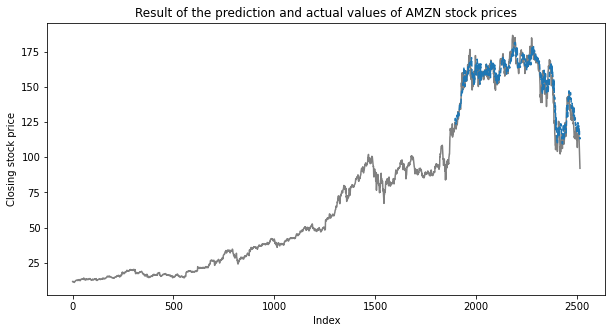

In [19]:
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model)
plt.title("Result of the prediction and actual values of AMZN stock prices")
plt.xlabel('Index')
plt.ylabel('Closing stock price')
plt.savefig('amazon.jpg')

20/20 [==============================] - 0s 4ms/step


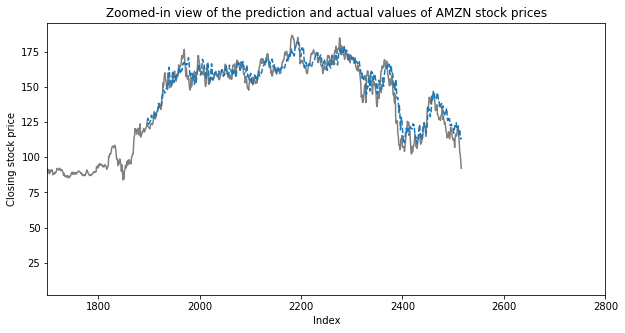

In [21]:
# Zooming in on the predicted and actual values to access performance of the model
%matplotlib inline
plt.figure(figsize=[10,5])
plot_pred(model)
plt.xlim(1700,2800)
plt.title("Zoomed-in view of the prediction and actual values of AMZN stock prices")
plt.xlabel('Index')
plt.ylabel('Closing stock price')
plt.savefig('amazon.jpg')

The model does a great job in predicting the daily stock price and captures the fine patterns of the actual values.